In [ ]:
###############################
# CarND-Behavioral-Cloning-P3 #
###############################

# Author: Michael
# 153792051@qq.com
# fengjihua@live.com

In [1]:
# Import Library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Cropping2D, Lambda, Conv2D, Activation, Dropout, Flatten, Dense
import h5py

print('TensorFlow Version: {}'.format(tf.__version__))
print('Keras Version: {}'.format(keras.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Using TensorFlow backend.


TensorFlow Version: 1.0.0
Keras Version: 2.1.1
Default GPU Device: /gpu:0


In [2]:
# Load Log and Images
df = pd.read_csv('./data/driving_log.csv')
df.tail(5)

,center,left,right,steering,throttle,brake,speed
8031,IMG/center_2016_12_01_13_46_38_745.jpg,IMG/left_2016_12_01_13_46_38_745.jpg,IMG/right_2016_12_01_13_46_38_745.jpg,0.0,0.0,0.0,1.402436
8032,IMG/center_2016_12_01_13_46_38_802.jpg,IMG/left_2016_12_01_13_46_38_802.jpg,IMG/right_2016_12_01_13_46_38_802.jpg,0.0,0.0,0.0,1.393976
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208
8035,IMG/center_2016_12_01_13_46_38_947.jpg,IMG/left_2016_12_01_13_46_38_947.jpg,IMG/right_2016_12_01_13_46_38_947.jpg,0.0,0.0,0.0,1.374433


(160, 320, 3)


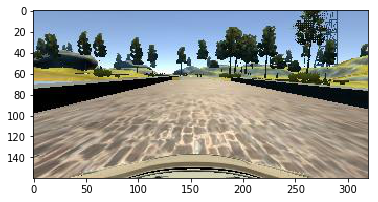

In [3]:
img = mpimg.imread('./data/{}'.format(df.loc[0]['center'])) 
print(img.shape)
plt.figure()
plt.imshow(img)
plt.show()

In [4]:
###################
# Preprocess Data #
###################
data = np.array(df)

# Option 1: Split train and valid set
train_data, valid_data = train_test_split(data, test_size=0.2)
print(len(data), len(train_data), len(valid_data))
print(train_data[0])
print(valid_data[0])

# Option 2 (Advanced): KFold split
# kf = KFold(n_splits=5, shuffle=True)
# for train_data, valid_data in kf.split(data):
#     print("Train data:",len(train_data), ",Test data:",len(valid_data))

8036 6428 1608
['IMG/center_2016_12_01_13_42_34_984.jpg'
 ' IMG/left_2016_12_01_13_42_34_984.jpg'
 ' IMG/right_2016_12_01_13_42_34_984.jpg' 0.0 0.9855325999999999 0.0
 30.186609999999998]
['IMG/center_2016_12_01_13_40_08_747.jpg'
 ' IMG/left_2016_12_01_13_40_08_747.jpg'
 ' IMG/right_2016_12_01_13_40_08_747.jpg' 0.0 0.0 0.0 9.223367]


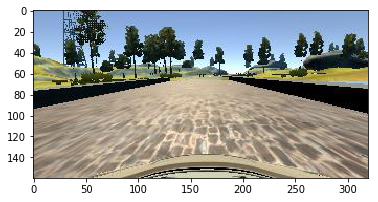

In [5]:
# Data Aumentation Test
img_flip = np.fliplr(img)
plt.figure()
plt.imshow(img_flip)
plt.show()

In [37]:
###############
# Build Model #
###############
model = Sequential()

# Crop the region not interested, top 50 pixels and bottom 20 pixels
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

# Normalize image: x / 255.0 - 0.5
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

# Conv1
model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid'))
model.add(Activation('relu'))

# Conv2
model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid'))
model.add(Activation('relu'))

# Conv3
model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid'))
model.add(Activation('relu'))

# Conv4
model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))

# Conv5
model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))

# Dropout
model.add(Dropout(0.1))

# Flatten
model.add(Flatten())

# Fully Connected
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

(1, 90, 320, 3)


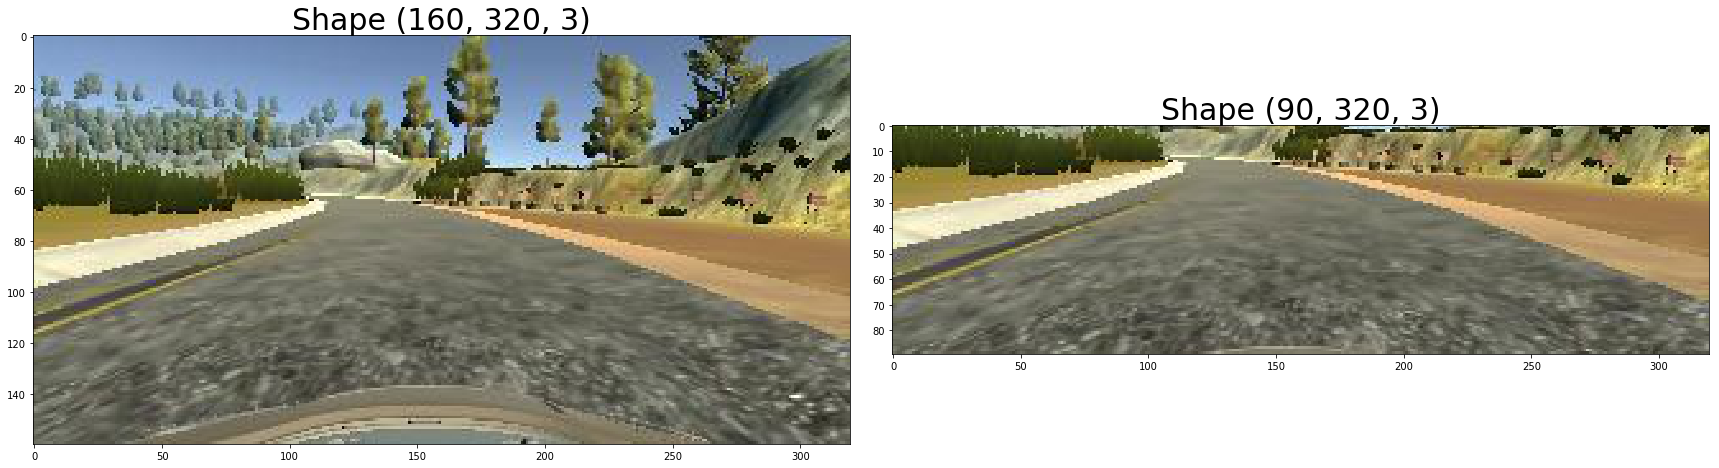

-0.5 0.5


In [28]:
####################
# Test model layer #
####################
def compare_images(left_image, right_image):    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(left_image)
    ax1.set_title('Shape '+ str(left_image.shape),
                  fontsize=30)
    ax2.imshow(np.uint8(right_image))
    ax2.set_title('Shape '+ str(right_image.shape)
                  , fontsize=30)
    plt.show()

input_img = []
input_img.append(mpimg.imread('./data/{}'.format(train_data[0][0])))

cropping_output = keras.backend.function([model.layers[0].input], [model.layers[0].output])
cropped_image = cropping_output([input_img])[0]
print(cropped_image.shape)
compare_images(input_img[0], cropped_image[0])

normalize_output = keras.backend.function([model.layers[0].output], [model.layers[1].output])
normalized_image = normalize_output([cropped_image])[0]
print(np.min(normalized_image), np.max(normalized_image))

In [40]:
###############
# Train Model #
###############
epochs = 5
batch_size = 32

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_name = './data/IMG/'+batch_sample[0].split('/')[-1]
                left_name = './data/IMG/'+batch_sample[1].split('/')[-1]
                right_name = './data/IMG/'+batch_sample[2].split('/')[-1]
                
                # angle factor
                angle = float(batch_sample[3])
                correction = 0.05
                if angle < 0:
                    correction = -correction
                
                # always train center image to keep drive center stable
                center_image = mpimg.imread(center_name)
                center_angle = angle
                images.append(center_image)
                angles.append(center_angle)

                center_image_flip = np.fliplr(center_image)
                center_angle_flip = -center_angle
                images.append(center_image_flip)
                angles.append(center_angle_flip)
                
                # train left and right image when abs(weer) > 0.4
                if np.absolute(angle) > 0.4:
#                     center_image = mpimg.imread(center_name)
#                     center_angle = angle + correction * 2
#                     images.append(center_image)
#                     angles.append(center_angle)

#                     center_image_flip = np.fliplr(center_image)
#                     center_angle_flip = -center_angle
#                     images.append(center_image_flip)
#                     angles.append(center_angle_flip)
                
                    left_image = mpimg.imread(left_name)
                    left_angle = angle + correction * 2
                    images.append(left_image)
                    angles.append(left_angle)

                    left_image_flip = np.fliplr(left_image)
                    left_angle_flip = -left_angle
                    images.append(left_image_flip)
                    angles.append(left_angle_flip)

                    right_image = mpimg.imread(right_name)
                    right_angle = angle + correction * 2
                    images.append(right_image)
                    angles.append(right_angle)

                    right_image_flip = np.fliplr(right_image)
                    right_angle_flip = -right_angle
                    images.append(right_image_flip)
                    angles.append(right_angle_flip)
                    
                    
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_data, batch_size=batch_size)
validation_generator = generator(valid_data, batch_size=batch_size)

model.compile(loss='mse', optimizer='adam')
# model.fit_generator(train_generator,
#                     samples_per_epoch=len(train_data),
#                     validation_data=validation_generator,
#                     nb_val_samples=len(valid_data),
#                     nb_epoch=epoch)
history_object = model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=validation_generator,
                    validation_steps=len(valid_data)/batch_size,
                    epochs=epochs)

print('Train Finished.')

Epoch 1/5
201/200 [==============================] - 37s 185ms/step - loss: 0.0155 - val_loss: 0.0183
Epoch 2/5
201/200 [==============================] - 36s 181ms/step - loss: 0.0149 - val_loss: 0.0183
Epoch 3/5
201/200 [==============================] - 36s 181ms/step - loss: 0.0146 - val_loss: 0.0183
Epoch 4/5
201/200 [==============================] - 36s 181ms/step - loss: 0.0144 - val_loss: 0.0180
Epoch 5/5
201/200 [==============================] - 36s 180ms/step - loss: 0.0139 - val_loss: 0.0179
Train Finished.


Save Model.
dict_keys(['val_loss', 'loss'])


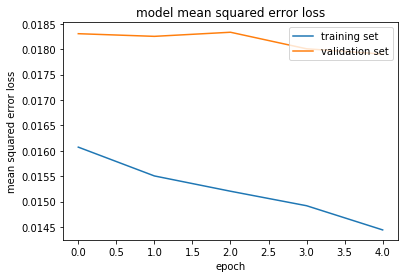

In [41]:
model.save('model.h5')
model.save_weights('model_weights.h5')
json_string = model.to_json()  
open('model.json','w').write(json_string)
print('Save Model.')

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()